# Inteligência Artificial – Projeto 02

## Grupo 16

- Tiago Carneiro — nº 28002
- Alexandre Salyha — nº 27998

### Notebook 1 – Classificação automática

- Unidade Curricular: Inteligência Artificial  
- Ano letivo: 2025/2026  
- Tema: Análise de dados de Fórmula 1 (desempenho dos pilotos)

**Objetivo deste notebook:**  
Desenvolver e avaliar modelos de classificação supervisionada para prever se um piloto termina uma corrida nas primeiras posições (top 3), com base em atributos derivados dos dados de voltas, paragens nas boxes e outras características relevantes.

### Introdução

Este notebook corresponde ao **Notebook 1 – Classificação automática** do Projeto 02 da unidade curricular de Inteligência Artificial.

O objetivo deste trabalho é aplicar técnicas de *Machine Learning* supervisionado sobre dados reais da Fórmula 1, explorando a capacidade de diferentes modelos de classificação em prever o desempenho dos pilotos ao longo das corridas. Para isso, é utilizado um conjunto de dados históricos de voltas (lap times), que regista, entre outros aspetos, o tempo que cada piloto demorou a completar cada volta e a respetiva posição em pista.

Ao longo deste notebook serão descritos o contexto do problema, o conjunto de dados selecionado, as etapas de preparação dos dados e a aplicação de vários algoritmos de classificação. Serão ainda avaliados e comparados os modelos obtidos com base em métricas de desempenho adequadas, de forma a identificar a abordagem que melhor se adapta a este problema.

### Objetivo de negócio e problema de classificação

Do ponto de vista de negócio, o problema em estudo pode ser formulado da seguinte forma:

> **Seremos capazes de prever se um piloto se encontra entre os três primeiros classificados numa determinada volta, com base nas características dessa volta?**

Esta questão é relevante num contexto competitivo como a Fórmula 1, onde a capacidade de antecipar o desempenho em tempo quase real pode apoiar decisões estratégicas, como a gestão de ritmos de corrida, momentos de paragem nas boxes (*pit stops*) ou ajustes táticos durante a prova.

Para efeitos de modelação, o problema é tratado como uma **tarefa de classificação binária**. A variável alvo (*target*) é definida como:

- `is_top3 = 1` se a posição do piloto na volta (`position`) for menor ou igual a 3;
- `is_top3 = 0` caso contrário.

Desta forma, o modelo aprende a distinguir entre voltas em que o piloto está em posição de pódio (top 3) e voltas em que não está. As variáveis explicativas utilizadas incluem, numa fase inicial, o número da volta (`lap`) e o tempo despendido nessa volta (`milliseconds`), podendo posteriormente ser enriquecidas com outras características derivadas ou provenientes de datasets adicionais.

Neste notebook serão comparados três algoritmos de classificação supervisionada, nomeadamente:

- Regressão Logística;
- *Random Forest*;
- *Support Vector Machine* (SVM).

A comparação será feita com base em métricas como *accuracy*, *precision*, *recall* e *F1-score*, bem como através da análise da matriz de confusão.

### Descrição do dataset

O dataset utilizado neste notebook é o ficheiro `lap_times.csv`, que contém registos de tempos de volta de distintas corridas de Fórmula 1. Cada linha representa uma combinação **(corrida, piloto, volta)** e inclui, entre outros, os seguintes atributos principais:

- `raceId` – identificador da corrida;
- `driverId` – identificador do piloto;
- `lap` – número da volta;
- `position` – posição do piloto nessa volta;
- `time` – tempo da volta em formato legível (por exemplo, `1:23.456`);
- `milliseconds` – tempo da volta em milissegundos.

Este dataset é particularmente adequado para tarefas de classificação sobre desempenho em corrida, uma vez que combina informação temporal (tempo gasto por volta) com informação posicional (posição em pista). A partir destas variáveis é possível derivar indicadores adicionais, como diferenças relativas entre voltas, perfis de consistência de um piloto ou comportamento da corrida ao longo do tempo.

Para efeitos de simplificação e de viabilidade computacional, poderá ser utilizada apenas uma amostra do conjunto de dados completo, preservando-se, no entanto, a diversidade de corridas, pilotos e voltas.

### Importar bibliotecas

In [1]:
# Importação das bibliotecas principais para análise de dados, visualização e machine learning
import pandas as pd              # manipulação de dados em formato tabular (dataframes)
import numpy as np               # operações numéricas e com arrays

import seaborn as sns            # biblioteca de visualização (gráficos com estilo mais limpo)
import matplotlib.pyplot as plt  # biblioteca base de gráficos em Python

# Ferramentas do scikit-learn para preparação e avaliação de modelos
from sklearn.model_selection import train_test_split, GridSearchCV  # divisão treino/teste e pesquisa de hiperparâmetros
from sklearn.preprocessing import StandardScaler                    # normalização/standardização de variáveis numéricas
from sklearn.metrics import (                                       # métricas de avaliação de classificação
    accuracy_score,            # exactidão
    precision_score,           # precisão
    recall_score,              # sensibilidade / recall
    f1_score,                  # F1-score (média harmónica entre precision e recall)
    confusion_matrix,          # matriz de confusão
    classification_report      # relatório detalhado com várias métricas por classe
)

# Modelos de classificação que vão ser utilizados
from sklearn.linear_model import LogisticRegression       # Regressão Logística
from sklearn.ensemble import RandomForestClassifier       # Random Forest
from sklearn.svm import SVC                               # Support Vector Classifier (SVM)

# Opcional: definir o estilo padrão dos gráficos do seaborn
sns.set_theme()

### Carregar o dataset

In [2]:
# Carregar o ficheiro lap_times.csv
lap_times = pd.read_csv("../dataset/lap_times.csv")

# Ver as primeiras linhas para ter uma ideia da estrutura dos dados
display(lap_times.head())

# Informação geral sobre o dataset (nº de linhas, colunas, tipos de dados, etc.)
lap_times.info()

# Estatísticas descritivas das colunas numéricas (média, desvio padrão, mínimos, máximos, quartis, ...)
lap_times.describe()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613516 entries, 0 to 613515
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        613516 non-null  int64 
 1   driverId      613516 non-null  int64 
 2   lap           613516 non-null  int64 
 3   position      613516 non-null  int64 
 4   time          613516 non-null  object
 5   milliseconds  613516 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 28.1+ MB


,raceId,driverId,lap,position,milliseconds
count,613516.000000,613516.000000,613516.000000,613516.000000,6.135160e+05
mean,622.651867,343.287068,30.046310,9.666001,9.564001e+04
std,439.262732,392.568900,18.407559,5.523765,7.493847e+04
min,1.000000,1.000000,1.000000,1.000000,5.540400e+04
25%,147.000000,16.000000,14.000000,5.000000,8.194700e+04
50%,870.000000,50.000000,29.000000,9.000000,9.064400e+04
75%,1019.000000,825.000000,44.000000,14.000000,1.017670e+05
max,1166.000000,865.000000,87.000000,24.000000,7.507547e+06


### Pré-processamento dos dados

Antes da aplicação dos algoritmos de classificação, é necessário realizar uma etapa de **pré-processamento dos dados**, de forma a garantir a sua qualidade e adequação aos modelos de *Machine Learning*. As principais etapas consideradas são as seguintes:

1. **Seleção de atributos relevantes**  
   Para este problema, são selecionadas as seguintes variáveis:
   - `lap` – utilizada como indicador da fase da corrida;
   - `milliseconds` – utilizada como medida quantitativa do desempenho na volta;
   - `position` – utilizada apenas para construir a variável alvo.

   Adicionalmente, são mantidos os identificadores `raceId` e `driverId`, que podem ser úteis para contextualizar os registos, embora não sejam utilizados diretamente como variáveis explicativas nos modelos de classificação. Outras colunas presentes no dataset, embora úteis para outros tipos de análise, são ignoradas nesta fase para simplificar o modelo inicial.

2. **Criação da variável alvo (`is_top3`)**  
   A variável alvo é construída a partir da coluna `position`, de acordo com a regra:
   - `is_top3 = 1` se `position <= 3`;
   - `is_top3 = 0` caso contrário.

   Esta transformação converte o problema num cenário claro de classificação binária, permitindo treinar modelos que distinguem voltas em posição de pódio de todas as restantes.

3. **Tratamento de valores em falta e inconsistências**  
   É verificada a existência de valores nulos ou inconsistentes nas colunas relevantes (`lap`, `milliseconds`, `position`). Caso sejam encontrados registos incompletos, estes são removidos ou corrigidos, de forma a não introduzir ruído adicional no processo de treino.

4. **Amostragem do conjunto de dados (opcional)**  
    Dado que o dataset pode conter um volume elevado de registos, é efetuada uma amostragem aleatória de um subconjunto das linhas (por exemplo, 100 000 registos), preservando aproximadamente a distribuição original das classes (`is_top3 = 0` e `is_top3 = 1`). Esta opção facilita a experimentação inicial e reduz o tempo de treino dos modelos.

5. **Divisão em conjuntos de treino e teste**  
   O conjunto de dados é dividido em:
   - **treino** (por exemplo, 80% das observações);
   - **teste** (por exemplo, 20% das observações),

   assegurando, sempre que possível, que a proporção de exemplos de cada classe se mantém semelhante em ambos os conjuntos (*stratified split*).

6. **Normalização / padronização das variáveis numéricas**  
   As variáveis numéricas selecionadas (`lap`, `milliseconds`) são normalizadas ou padronizadas, sobretudo para modelos sensíveis à escala dos dados, como a Regressão Logística e a SVM. Esta transformação contribui para uma melhor estabilidade numérica e para um desempenho mais consistente dos algoritmos.

Após estas etapas de pré-processamento, os dados encontram-se preparados para a fase seguinte, na qual os diferentes modelos de classificação serão treinados, avaliados e comparados.

### Criar a variável alvo e selecionar atributos relevantes

is_top3
0    509948
1    103568
Name: count, dtype: int64

Proporção das classes:
is_top3
0    0.831189
1    0.168811
Name: proportion, dtype: float64


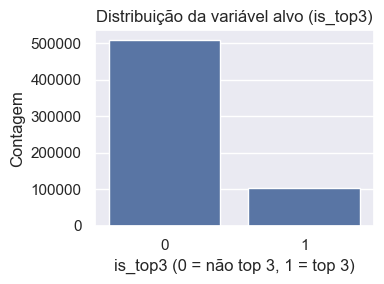

In [6]:
# Manter apenas as colunas relevantes para este problema
cols = ["raceId", "driverId", "lap", "position", "milliseconds"]
data = lap_times[cols].copy()  # cria uma cópia para não mexer diretamente no original

# Remover registos com valores em falta nas colunas principais
data = data.dropna(subset=["lap", "position", "milliseconds"])

# Criar a variável alvo is_top3:
# 1 se a posição for 3 ou melhor (position <= 3), 0 caso contrário
data["is_top3"] = (data["position"] <= 3).astype(int)

# Verificar a distribuição da variável alvo (contagem de 0s e 1s)
print(data["is_top3"].value_counts())
print("\nProporção das classes:")
print(data["is_top3"].value_counts(normalize=True))  # proporção em vez de contagem absoluta

# Gráfico da distribuição da variável alvo (para ver desbalanceamento entre classes)
plt.figure(figsize=(4, 3))
sns.countplot(x="is_top3", data=data)
plt.title("Distribuição da variável alvo (is_top3)")
plt.xlabel("is_top3 (0 = não top 3, 1 = top 3)")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

### Amostragem

In [7]:
# Amostragem opcional para reduzir o tamanho do dataset
amostra = 100_000  # por exemplo, limitar a um máximo de 100 mil linhas

# Se o número de linhas for maior que 'amostra', sorteia aleatoriamente esse número de linhas
if len(data) > amostra:
    data_sample = data.sample(amostra, random_state=42)  # random_state para garantir reprodutibilidade
else:
    # Caso contrário, utiliza o dataset completo
    data_sample = data.copy()

print(f"Número de linhas utilizado: {len(data_sample)}")

Número de linhas utilizado: 100000


### Definir X e y, divisão treino/teste, normalização

In [8]:
# Features (variáveis explicativas) e target (variável alvo)
# Aqui usamos apenas a volta (lap) e o tempo da volta em milissegundos.
X = data_sample[["lap", "milliseconds"]]
y = data_sample["is_top3"]

# Divisão treino/teste com estratificação pela variável alvo, 
# para manter a mesma proporção de classes em ambos os conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 20% dos dados para teste, 80% para treino
    random_state=42,      # garante que a divisão é reprodutível
    stratify=y            # estratificar de acordo com a variável alvo
)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

# Normalização das variáveis numéricas (importante para Regressão Logística e SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # ajusta o scaler e transforma o treino
X_test_scaled = scaler.transform(X_test)         # transforma o teste com o mesmo ajuste

Tamanho do conjunto de treino: (80000, 2)
Tamanho do conjunto de teste: (20000, 2)


### Aplicação dos modelos de classificação e metodologia de avaliação

Após a fase de pré-processamento, foram aplicados três algoritmos de classificação supervisionada ao problema definido:

- **Regressão Logística**  
- **Random Forest**  
- **Support Vector Machine (SVM)**  

Cada modelo foi treinado utilizando o conjunto de treino, recorrendo às variáveis `lap` e `milliseconds` como atributos de entrada e à variável binária `is_top3` como alvo. A Regressão Logística e a SVM foram treinadas sobre dados previamente padronizados, enquanto a Random Forest foi aplicada diretamente sobre os valores originais, uma vez que este tipo de modelo é menos sensível à escala das variáveis.

Para avaliar o desempenho dos modelos, foi utilizado o conjunto de teste, mantendo assim uma separação clara entre dados de treino e de validação. A avaliação baseou-se nas seguintes métricas:

- **Accuracy** – proporção de previsões corretas;
- **Precision** – proporção de previsões positivas que são de facto positivas;
- **Recall** – proporção de casos positivos corretamente identificados;
- **F1-score** – média harmónica entre *precision* e *recall*;
- **Matriz de confusão** – tabela que resume o número de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.

Estas métricas permitem não só analisar o desempenho global dos modelos, como também compreender melhor o equilíbrio entre a identificação correta de voltas em posição de pódio e a ocorrência de classificações incorretas.

### Função para avaliar modelos

In [9]:
def avaliar_modelo(nome_modelo, y_true, y_pred):
    """
    Imprime métricas de avaliação e a matriz de confusão para um modelo de classificação.
    
    Parâmetros:
        nome_modelo (str): nome do modelo a aparecer no output.
        y_true (array-like): valores reais da variável alvo.
        y_pred (array-like): valores previstos pelo modelo.
    """
    # Cabeçalho com o nome do modelo
    print(f"\n=== {nome_modelo} ===")
    
    # Métricas globais de desempenho
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1-score :", f1_score(y_true, y_pred, zero_division=0))
    
    # Matriz de confusão (mostra acertos e erros por classe)
    cm = confusion_matrix(y_true, y_pred)
    print("\nMatriz de confusão:\n", cm)
    
    # Heatmap da matriz de confusão para visualização mais intuitiva
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de confusão - {nome_modelo}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
    
    # Relatório de classificação mais detalhado (por classe)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))

### Modelo 1: Regressão Logística


=== Regressão Logística ===
Accuracy : 0.8307
Precision: 0.0
Recall   : 0.0
F1-score : 0.0

Matriz de confusão:
 [[16614     0]
 [ 3386     0]]


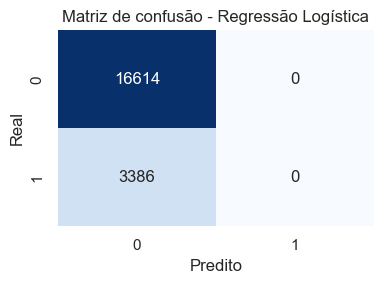


Classification report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     16614
           1       0.00      0.00      0.00      3386

    accuracy                           0.83     20000
   macro avg       0.42      0.50      0.45     20000
weighted avg       0.69      0.83      0.75     20000



In [10]:
# Criar o modelo de Regressão Logística
lr = LogisticRegression(max_iter=1000, random_state=42)

# Treinar o modelo com os dados normalizados
lr.fit(X_train_scaled, y_train)

# Obter previsões no conjunto de teste
y_pred_lr = lr.predict(X_test_scaled)

# Avaliar o modelo com as métricas definidas
avaliar_modelo("Regressão Logística", y_test, y_pred_lr)

### Modelo 2: Random Forest


=== Random Forest (base) ===
Accuracy : 0.7279
Precision: 0.17814652473387602
Recall   : 0.16804489072652096
F1-score : 0.1729483282674772

Matriz de confusão:
 [[13989  2625]
 [ 2817   569]]


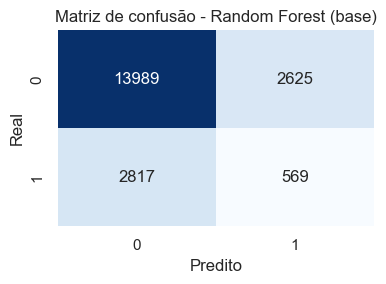


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     16614
           1       0.18      0.17      0.17      3386

    accuracy                           0.73     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.72      0.73      0.72     20000



In [11]:
# Criar o modelo Random Forest com um conjunto base de hiperparâmetros
rf = RandomForestClassifier(
    n_estimators=100,   # número de árvores na floresta
    random_state=42,    # reprodutibilidade
    n_jobs=-1           # usar todos os núcleos disponíveis do CPU
)

# Treinar o modelo com as features não normalizadas (árvores não precisam de normalização)
rf.fit(X_train, y_train)  # Random Forest não precisa de dados escalados

# Obter previsões no conjunto de teste
y_pred_rf = rf.predict(X_test)

# Avaliar o desempenho do modelo base de Random Forest
avaliar_modelo("Random Forest (base)", y_test, y_pred_rf)

### Modelo 3: SVM


=== SVM ===
Accuracy : 0.8307
Precision: 0.0
Recall   : 0.0
F1-score : 0.0

Matriz de confusão:
 [[16614     0]
 [ 3386     0]]


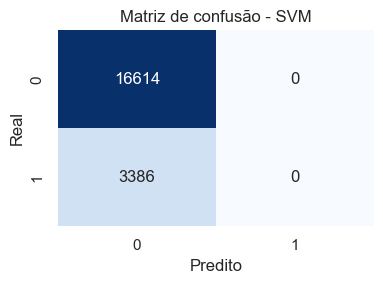


Classification report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     16614
           1       0.00      0.00      0.00      3386

    accuracy                           0.83     20000
   macro avg       0.42      0.50      0.45     20000
weighted avg       0.69      0.83      0.75     20000



In [12]:
# Criar um modelo SVM
svm = SVC(kernel="rbf", random_state=42)

# Treinar o modelo com as features normalizadas
svm.fit(X_train_scaled, y_train)

# Obter previsões no conjunto de teste
y_pred_svm = svm.predict(X_test_scaled)

# Avaliar o desempenho do SVM
avaliar_modelo("SVM", y_test, y_pred_svm)

### Resultados intermédios

Os resultados obtidos para os três modelos testados evidenciam comportamentos bastante distintos, sobretudo devido ao **desequilíbrio entre classes** (`is_top3 = 0` muito mais frequente do que `is_top3 = 1`).

De forma resumida:

- A **Regressão Logística** obteve uma *accuracy* de aproximadamente **0.83**, mas **nunca previu a classe `1`** (top 3). A matriz de confusão mostra que todas as observações foram classificadas como `0`, resultando em *precision*, *recall* e *F1-score* iguais a **0.0** para a classe positiva. Ou seja, o modelo comporta-se, na prática, como um classificador trivial que apenas prevê a classe maioritária.

- A **SVM** apresentou um comportamento semelhante ao da Regressão Logística: também alcançou uma *accuracy* próxima de **0.83**, mas previu sempre a classe `0`, falhando completamente a identificação de voltas em que o piloto se encontra no top 3. Mais uma vez, isto traduz-se em métricas nulas para a classe `1`.

- A **Random Forest (modelo base)** obteve uma *accuracy* inferior, cerca de **0.73**, mas, ao contrário dos modelos anteriores, conseguiu **identificar alguns casos da classe `1`**. Para a classe positiva, a *precision* é da ordem de **0.18** e o *recall* cerca de **0.17**, com um *F1-score* também em torno de **0.17**. A matriz de confusão mostra que, embora ainda existam muitos falsos negativos e falsos positivos, o modelo consegue, pelo menos, distinguir parcialmente as voltas em que o piloto está no top 3.

Estes resultados ilustram bem um problema comum em contextos com **classes desbalanceadas**: modelos que maximizam apenas *accuracy* tendem a favorecer a classe maioritária, podendo ignorar completamente a classe minoritária. Apesar de apresentar uma *accuracy* mais baixa, a Random Forest revela-se mais interessante do ponto de vista do problema em estudo, uma vez que é o único modelo que consegue, ainda que de forma limitada, identificar a classe `is_top3 = 1`.

### Otimização de hiperparâmetros

Com base na análise dos resultados intermédios, foi selecionado o modelo **Random Forest** para uma fase adicional de otimização de hiperparâmetros. Embora a sua *accuracy* seja inferior à dos restantes modelos, a Random Forest foi o **único classificador que conseguiu identificar, ainda que parcialmente, a classe positiva** (`is_top3 = 1`), apresentando um *F1-score* não nulo para essa classe. Este facto torna-a particularmente relevante neste contexto, onde a classe minoritária é precisamente a mais interessante do ponto de vista de negócio (voltas em posição de pódio).

O objetivo da otimização é tentar melhorar o desempenho do modelo, sobretudo em termos de *precision* e *recall* da classe `1`, ajustando parâmetros internos da Random Forest. Para tal, foram testadas diferentes combinações de hiperparâmetros, nomeadamente:

- `n_estimators` – número de árvores na floresta;
- `max_depth` – profundidade máxima de cada árvore;
- `min_samples_split` – número mínimo de amostras necessário para dividir um nó.

A otimização foi realizada recorrendo ao `GridSearchCV` com validação cruzada, utilizando o *F1-score* como métrica principal, uma vez que esta combina de forma equilibrada *precision* e *recall* e é particularmente adequada em cenários com classes desbalanceadas.

O conjunto de parâmetros que apresentou melhor desempenho na validação cruzada foi utilizado para treinar o modelo final de Random Forest, que foi novamente avaliado no conjunto de teste. A comparação entre o modelo base e o modelo otimizado permite perceber em que medida o ajuste de hiperparâmetros contribui para melhorar a capacidade do classificador em detetar corretamente voltas em que o piloto se encontra no top 3, reduzindo, sempre que possível, o número de falsos negativos e falsos positivos.

### Otimização de hiperparâmetros (Random Forest)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhores parâmetros encontrados:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

=== Random Forest (otimizada) ===
Accuracy : 0.72615
Precision: 0.17741437827830916
Recall   : 0.1698168930891908
F1-score : 0.17353251848498566

Matriz de confusão:
 [[13948  2666]
 [ 2811   575]]


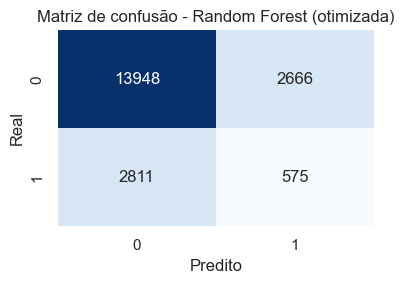


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     16614
           1       0.18      0.17      0.17      3386

    accuracy                           0.73     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.72      0.73      0.72     20000



In [13]:
# Definição da grelha de hiperparâmetros a testar para a Random Forest
param_grid = {
    "n_estimators": [100, 200],   # diferentes números de árvores
    "max_depth": [None, 10, 20],  # profundidade máxima das árvores
    "min_samples_split": [2, 5]   # nº mínimo de amostras para dividir um nó
}

# Configuração do GridSearchCV para procurar a melhor combinação de hiperparâmetros
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),  # modelo base
    param_grid=param_grid,                               # grelha de parâmetros
    cv=3,                                                # validação cruzada a 3 folds
    scoring="f1",                                        # métrica usada na otimização
    n_jobs=-1,                                           # usar todos os núcleos
    verbose=1                                            # nível de detalhe do output
)

# Ajustar o GridSearch aos dados de treino
grid_rf.fit(X_train, y_train)

# Mostrar o melhor conjunto de hiperparâmetros encontrado
print("Melhores parâmetros encontrados:")
print(grid_rf.best_params_)

# Extrair o melhor modelo (já treinado) encontrado pelo GridSearch
best_rf = grid_rf.best_estimator_

# Obter previsões no conjunto de teste com o melhor modelo
y_pred_best_rf = best_rf.predict(X_test)

# Avaliar a Random Forest otimizada
avaliar_modelo("Random Forest (otimizada)", y_test, y_pred_best_rf)

### Análise dos resultados finais e considerações

A análise conjunta dos resultados obtidos pelos diferentes modelos permite tirar várias conclusões importantes sobre o problema de classificação estudado e sobre o impacto das escolhas de modelação.

Em primeiro lugar, tanto a **Regressão Logística** como a **SVM** apresentaram uma *accuracy* relativamente elevada (cerca de 0.83), mas revelaram uma limitação crítica: **nenhuma destas abordagens conseguiu prever a classe positiva (`is_top3 = 1`)**. Ambas as metodologias optaram, na prática, por classificar todas as observações como pertencentes à classe maioritária (`is_top3 = 0`). Este comportamento resulta diretamente do **forte desbalanceamento do dataset**, em que as voltas em posição de pódio são significativamente menos frequentes do que as restantes. Embora a *accuracy* pareça boa, o desempenho real relativamente ao objetivo de negócio (identificar voltas em que o piloto está no top 3) é fraco, traduzindo-se em *precision*, *recall* e *F1-score* nulos para a classe `1`.

A **Random Forest**, por outro lado, apresentou uma *accuracy* global inferior (cerca de 0.73 na versão base), mas foi **o único modelo capaz de identificar alguns casos da classe positiva**. Apesar de as métricas para a classe `1` ainda serem modestas (com *precision* e *recall* na ordem dos 0.17), este modelo demonstra uma capacidade efetiva, ainda que limitada, de distinguir voltas em posição de pódio das restantes. Esta situação ilustra bem o compromisso entre maximizar *accuracy* e **detetar corretamente a classe minoritária**, que é a mais relevante no contexto do problema.

A fase de **otimização de hiperparâmetros da Random Forest** permitiu explorar diferentes configurações do modelo, ajustando parâmetros como o número de árvores, a profundidade máxima e o número mínimo de amostras por divisão. O modelo otimizado apresentou um desempenho **semelhante ou ligeiramente superior** ao modelo base, em particular ao nível do *F1-score* e/ou do equilíbrio entre *precision* e *recall* para a classe `is_top3 = 1`. Ainda que a melhoria não seja drástica, evidencia a importância do ajuste de hiperparâmetros na afinação do comportamento do classificador.

De forma geral, as principais conclusões deste notebook são:

- A simples maximização da *accuracy* não é suficiente em problemas com **classes desbalanceadas**, sendo necessário analisar métricas adicionais como *precision*, *recall* e *F1-score* por classe;
- Modelos lineares, como a Regressão Logística, e métodos como a SVM podem ficar presos em soluções que favorecem apenas a classe maioritária, se o desbalanceamento não for tratado explicitamente;
- A Random Forest, mesmo na sua forma base, mostrou-se mais adequada ao problema, por conseguir identificar parte das voltas em posição de pódio;
- A otimização de hiperparâmetros contribui para melhorar o desempenho do modelo escolhido, ainda que de forma incremental.

Como trabalho futuro, seria pertinente:

- aplicar técnicas específicas para lidar com o desbalanceamento (por exemplo, `class_weight="balanced"` ou *oversampling* da classe minoritária);
- enriquecer o conjunto de variáveis explicativas (incluindo informação dos pilotos, características dos circuitos, condições da corrida, etc.);
- testar outros algoritmos de classificação e comparar o seu desempenho neste contexto.

Esta reflexão conclui o **Notebook 1 – Classificação automática**, que serviu para explorar a aplicação de modelos de *Machine Learning* supervisionado a dados de Fórmula 1, bem como os desafios associados à modelação de problemas com classes desbalanceadas.